In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()


In [20]:
df_hour = pd.read_csv("data/PJME_hourly.csv")

df_hour = df_hour.set_index('Datetime')

df_hour.index = pd.to_datetime(df_hour.index)

In [23]:
df_hour.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [15]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<AxesSubplot: title={'center': 'PJME in Mega Watts'}, xlabel='Datetime'>

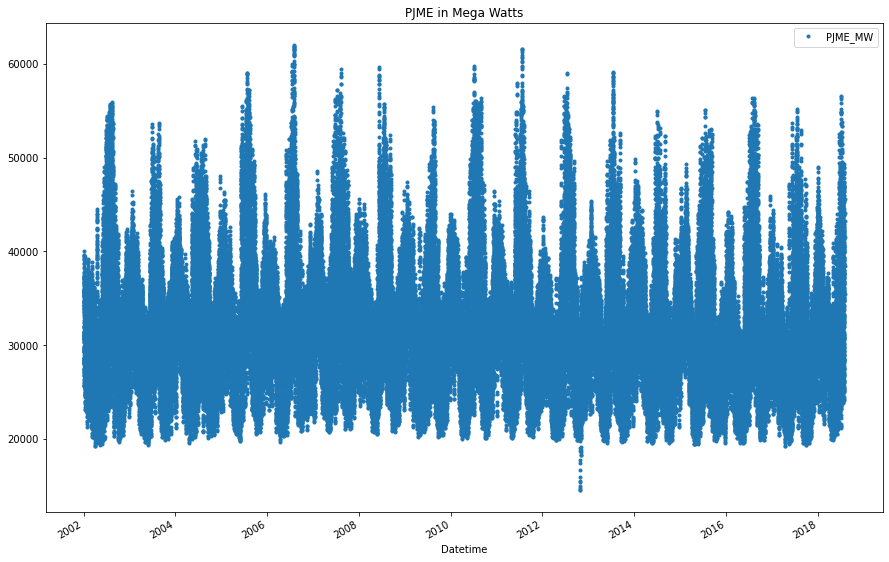

In [24]:
df_hour.plot(style='.',figsize=(15,10),color=color_pal[0],title='PJME in Mega Watts')

-----
-----

#### Train / Test split

In [25]:
train = df_hour.loc[df_hour.index < '01-01-2015']
test = df_hour.loc[df_hour.index >= '01-01-2015']

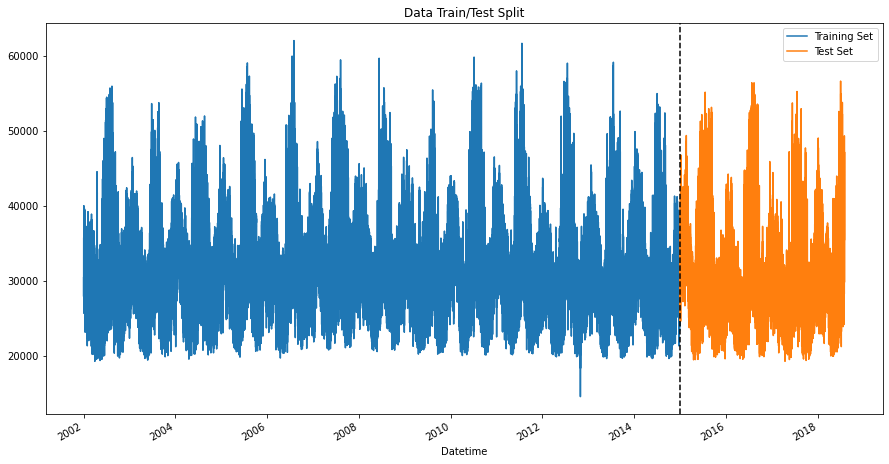

In [34]:
fig,ax = plt.subplots(figsize=(15,8))
train.plot(ax=ax,label='Train',title = "Data Train/Test Split")
test.plot(ax=ax,label='Test')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot: title={'center': 'Week data'}, xlabel='Datetime'>

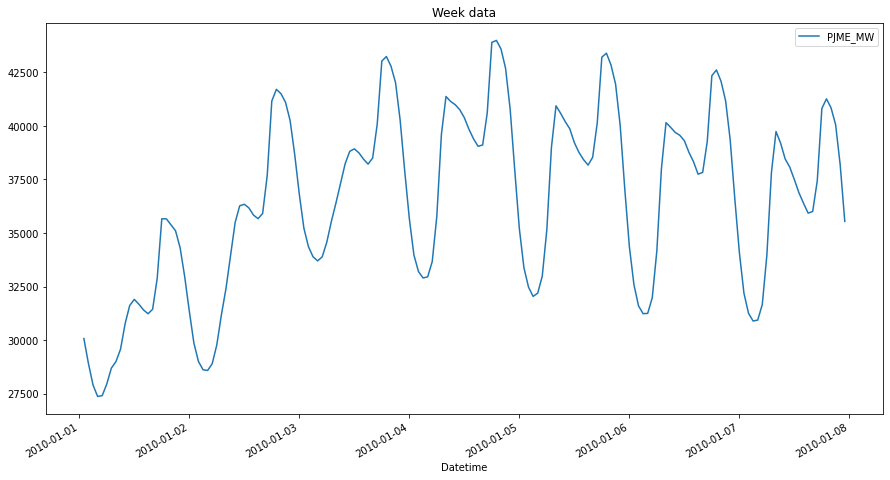

In [37]:
df_hour.loc[(df_hour.index>'01-01-2010' )& (df_hour.index<'01-08-2010')].plot(figsize=(15,8),title = "Week data")

### Feature Extraction

In [57]:
def create_feat(df_hour):
    df_hour = df_hour.copy()
    df_hour['hour'] = df_hour.index.hour
    df_hour['dayofweek'] = df_hour.index.dayofweek
    df_hour['quarter'] = df_hour.index.quarter
    df_hour['month'] = df_hour.index.month
    df_hour['year'] = df_hour.index.year
    df_hour['dayofyear'] = df_hour.index.dayofyear
    return df_hour

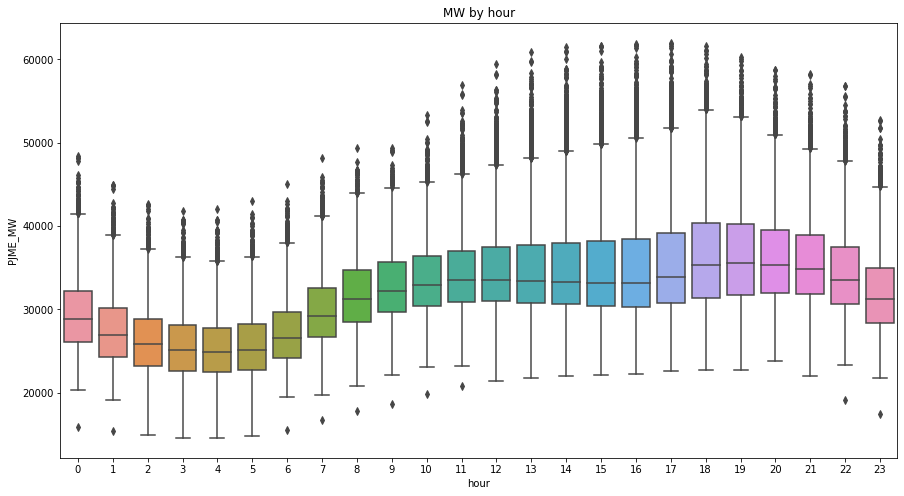

In [50]:
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df_hour,x='hour',y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

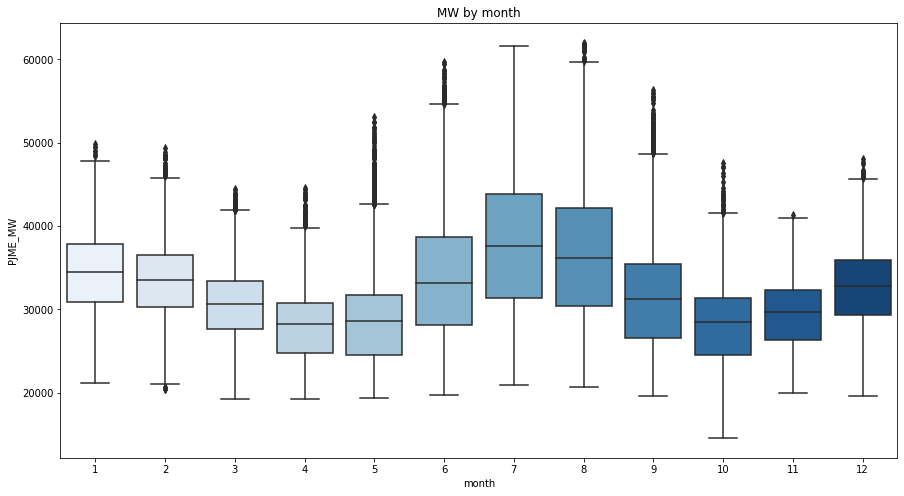

In [49]:
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df_hour,x='month',y='PJME_MW',palette='Blues')
ax.set_title('MW by month')
plt.show()

### Creating XgBoost regressor

In [74]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)

In [75]:
train = create_feat(train)
test = create_feat(test)

In [76]:
df_hour.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [77]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

In [78]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [79]:
reg.fit(X_train,y_train,
       eval_set = [(X_train,y_train),(X_test,y_test)],
       verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

In [84]:
fi = pd.DataFrame(reg.feature_importances_,index=reg.feature_names_in_,columns=['Importance'])

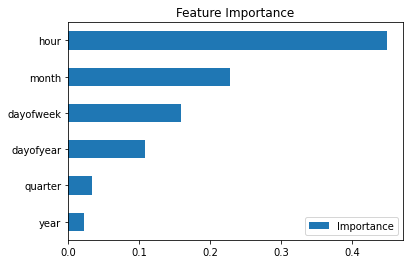

In [89]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance')
plt.show()

## Forecast on Test

In [90]:
test['Prediction'] = reg.predict(X_test)

In [95]:
df_hour = df_hour.merge(test[['Prediction']], how = 'left', left_index=True,right_index=True)

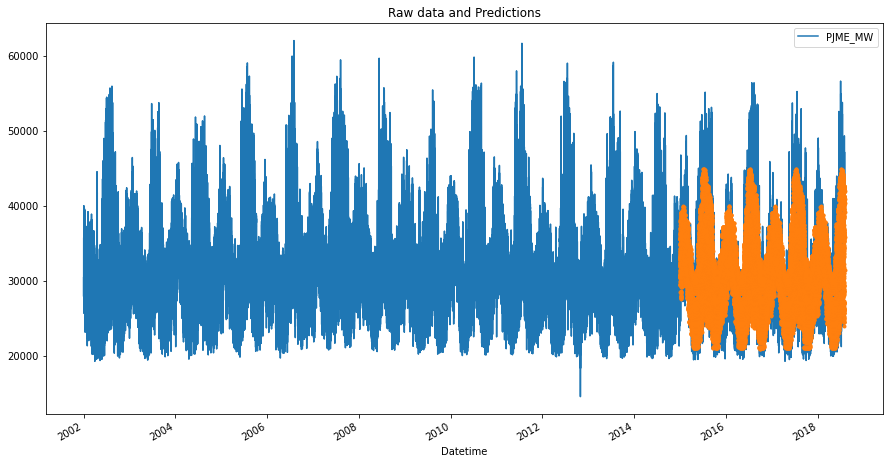

In [97]:
ax = df_hour[['PJME_MW']].plot(figsize=(15,8))
df_hour['Prediction'].plot(ax=ax,style='.')
ax.set_title('Raw data and Predictions')
plt.show()

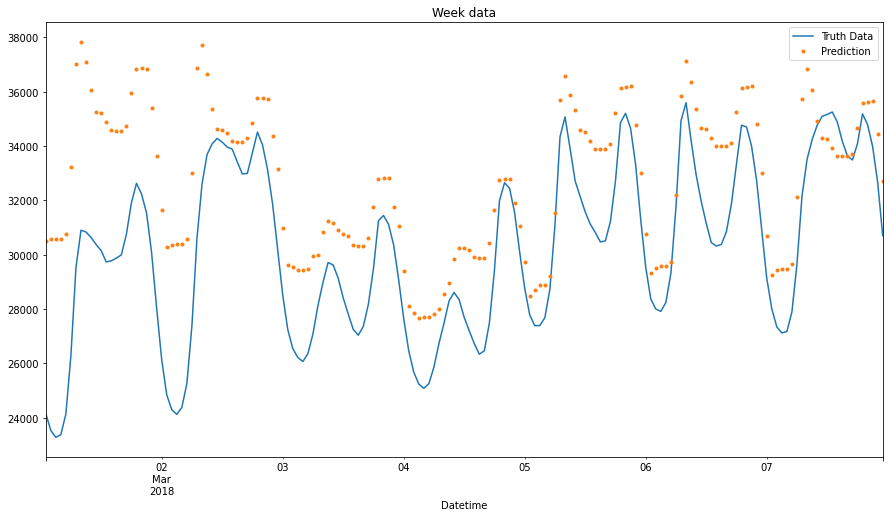

In [101]:
ax = df_hour.loc[(df_hour.index>'03-01-2018' )& (df_hour.index<'03-08-2018')]['PJME_MW'].plot(figsize=(15,8),title = "Week data")
df_hour.loc[(df_hour.index>'03-01-2018' )& (df_hour.index<'03-08-2018')]['Prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()